This notebook contains the cutting-edge of what i've got (pre-last-min-grind ofc)

For some reason, the modularity goes out the window as all functions used are defined within the notebook - to make prototypning easier - I don't think these have been integrated back into the module (Will need to be done)

For some reason, have assigned node status to be a number when could have easily used S, I, R (noob move)

We see decent agreement between neoroSIR and ODE (for a limited parameter space)

Work is done on decay mechanism but it is not too advanced, just eye-balled something that looks like exponenetial decay - CONFIRM

We show that a weighted SIR process following the basic protocol does not match ODE well at all (for parameter values which neuro SIR was shown to work well)

Unweighted SIR with not limit on connections formed shown to have good agreement with ODE (as one would expect)

There is a toy model to test that the propogation algorithm is working as intended

There is also a visualisation of the network when spreading - this is limited to a few nodes as beyonf this we run into conflicts between networkx and scipy that I am not able to resolve, tried to let chatGPT solve the problem but no luck.

In [15]:
import network_stats as ns
import network_manipulation as nm
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.integrate import odeint
import random

# should make this into a file to inport into every notebook
dataset_paths = [
'Sociopatterns datasets/conference_2009.dat_',
'Sociopatterns datasets/highschool_2011.csv',
'Sociopatterns datasets/highschool_2012.csv',
'Sociopatterns datasets/highschool_2013.csv',
'Sociopatterns datasets/hospital_2010.dat_',
'Sociopatterns datasets/primaryschool_2014.csv',
'Sociopatterns datasets/workplace_2013.dat',
'Sociopatterns datasets/workplace_2015.dat_']

dataset_names = [
    'Conference 1', 
    'Highschool 1', 
    'Highschool 2', 
    'Highschool 3', 
    'Hospital 1', 
    'Primaryschool 1', 
    'Workplace 1', 
    'Workplace 2']

In [16]:
def initialise_potential(G, initial, threshold): #look into more initialisation schemes
    nodes = list(G.nodes)
    for node in nodes:
        if random.random() < initial:
            G.nodes[node]['potential'] = threshold 
        else:
            G.nodes[node]['potential'] = 0
    return G

def initialise_status(G):
    '''
    1   :   susceptible
    0   :   infected
    -1  :   removed
    '''
    nodes = list(G.nodes)
    for node in nodes:
        if G.nodes[node]['potential'] == 0:
            G.nodes[node]['status'] = 1
        else:
            G.nodes[node]['status'] = 0
    return G

def initialise_weight(G, weight):
    nodes = list(G.nodes)
    for node in nodes:
        connections = list(G.neighbors(node))
        for connection in connections:
            G[node][connection]['weight'] = weight
    return G

In [17]:
def propagate(G, threshold, beta, gamma): # only fires if newly infected, no decay of potential
    nodes = list(G.nodes)
    
    update_dict = {}
    for node in nodes: # initialise dict to keep track of which nodes need to be updated and by how much
        update_dict[node] = 0
    
    for node in nodes: # finding which potential to increase
        if G.nodes[node]['status'] == 0: # if node is infected it should transmit disease and have prob of becoming recovered, first as these are actors
            connections = list(G.neighbors(node))
            for connection in connections:
                update_dict[connection] += beta * G[node][connection]['weight'] 
                
            #comp = 1 - np.exp(-gamma)
            comp = gamma
            
            if np.random.random() < comp: # some chance for infected nodes to become removed nodes
                G.nodes[node]['status'] = -1
    
    for node in nodes: # carrying out updates by looping over all susceptible nodes to increase potentials
        if G.nodes[node]['status'] == 1: # if a node is susceptible, it should be able to gain potential and can become infected
            G.nodes[node]['potential'] += update_dict[node]
            if G.nodes[node]['potential'] >= threshold: # if update pushes above threshold then infected
                G.nodes[node]['status'] = 0
            else: # otherwise there is decay
                pot = G.nodes[node]['potential']
                #decay = pot * np.exp(-pot / threshold)
                decay = 30
                G.nodes[node]['potential'] -= decay

    return G


In [18]:
def check_activity(G, threshold): # cumsum of infected nodes
    infected = 0
    nodes = list(G.nodes)
    for node in nodes:
        if G.nodes[node]['potential'] >= threshold:
            infected += 1
    return infected / len(G.nodes)

def check_activity(G): # cumsum of infected nodes
    total = 0
    nodes = list(G.nodes)
    for node in nodes:
        if  G.nodes[node]['status'] == 0:
            total+=1
    return total / len(G)

def check_removed(G):
    total = 0
    nodes = list(G.nodes)
    for node in nodes:
        if  G.nodes[node]['status'] == -1:
            total+=1
    return total / len(G)

def check_susecptible(G): # finds what fraction of nodes are susceptible
    total = 0
    nodes = list(G.nodes)
    for node in nodes:
        if  G.nodes[node]['status'] == 1:
            total+=1
    return total / len(G)

def check_states(G):
    s = check_susecptible(G)
    i = check_activity(G)
    r = check_removed(G)
    return s, i, r

def simulate(G, initial, threshold, T, beta, gamma): # add in infected per time step later
    susceptible = []
    infected = []
    removed = []
    
    G = initialise_potential(G, initial, threshold)
    G = initialise_status(G)
    
    s, i, r = check_states(G)
    susceptible.append(s)
    infected.append(i)
    removed.append(r)
    
    for t in range(T):
        G = propagate(G, threshold, beta, gamma)
        s, i, r = check_states(G)
        susceptible.append(s)
        infected.append(i)
        removed.append(r)
        
    return susceptible, infected, removed

def smooth(G, initial, threshold, T, M, beta, gamma):
    s_smooth = []
    i_smooth = []
    r_smooth = []
    s_runs = []
    i_runs = []
    r_runs = []
    for i in range(M):
        #print(str(round((i+1)*100/M, 1)) + '%') # display progress of smoothing
        s_run, i_run, r_run = simulate(G, initial, threshold, T, beta, gamma)
        s_runs.append(s_run)
        i_runs.append(i_run)
        r_runs.append(r_run)
    
    for i in range(T): # smoothing susceptible time series
        total = 0
        for j in range(M):
            total += s_runs[j][i]     
        total = total / M   
        s_smooth.append(total)
        
    for i in range(T): # smoothing infected time series
        total = 0
        for j in range(M):
            total += i_runs[j][i]     
        total = total / M   
        i_smooth.append(total)

    for i in range(T): # smoothing recovered time series
        total = 0
        for j in range(M):
            total += r_runs[j][i]     
        total = total / M   
        r_smooth.append(total)
    
    print(len(s_run[0]))
    print(len(s_smooth))
        
    return s_smooth, i_smooth, r_smooth

In [19]:
# Visualization

import os
import glob
from PIL import Image

def find_colours(G):
    colours = []
    for node in list(G.nodes):
        if G.nodes[node]['status'] == 1:
            colours.append('blue')
        elif G.nodes[node]['status'] == 0:
            colours.append('red')
        elif G.nodes[node]['status'] == -1:
            colours.append('green')
        else:
            colours.append('purple')
    return colours

def visualise(G, params, seed_val):
    
    files = glob.glob('/Users/ali/MSci Project/IF visualisation/frame*.png')
    for f in files:
        os.remove(f)
    
    G = initialise_potential(G, params['Initial'], params['Threshold'])
    G = initialise_status(G)
    plt.figure(figsize = (12, 8))
    if seed_val == None:
        positions = nx.spring_layout(G)
    else:
        positions = nx.spring_layout(G, seed = seed_val)
    
    colours = find_colours(G)
    plt.text(10,10,'time')
    nx.draw_networkx(G, pos = positions, with_labels = 0, node_size = 100, node_color = colours, alpha = 0.5)
    plt.savefig('/Users/ali/MSci Project/IF visualisation/frame' + str(0))
    plt.clf()
    
    for t in range(params['Time']):
        G = propagate(G, params['Threshold'], params['Beta'], params['Gamma'])
        colours = find_colours(G)
        nx.draw_networkx(G, pos = positions, with_labels = 0, node_size = 100, node_color = colours, alpha = 0.5)
        plt.savefig('/Users/ali/MSci Project/IF visualisation/frame' + str(t+1))
        plt.clf()
        
def make_gif():
    frames = []
    imgs = []
    path = '/Users/ali/MSci Project/IF visualisation/frame'
    total_frames = len(os.listdir('/Users/ali/MSci Project/IF visualisation/'))
    for i in range(total_frames):
        imgs.append(path + str(i) + '.png')
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)

    frames[0].save('/Users/ali/MSci Project/IF visualisation.gif', 
                format='GIF',
                append_images=frames[1:],
                save_all=True,
                duration=500) # duration of each frame in milliseconds!
    return frames

In [24]:
# SIR analytical solution

def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def analytic_sol(G, params):
    N = len(G)
    I0 = np.ceil(params['Initial'] * N)
    R0 = 0
    S0 = N - I0 - R0
    t = np.arange(0, params['Time'], 1)
    y0 = S0, I0, R0 # Initial conditions vector
    ret = odeint(deriv, y0, t, args=(N, params['Beta'], params['Gamma']))
    S, I, R = ret.T
    return S/N, I/N, R/N

def comparison(G, params, name = 'Placeholder'):
    plt.figure(figsize=(8, 6))
    plt.grid()
    #plt.ylim(0, 1.2)
    analytic_time = np.arange(0, params['Time'])
    S, I, R = analytic_sol(G, params)

    plt.plot(analytic_time, S, linewidth = 3, label = 'Susceptible', color = 'b', linestyle = 'dashed', alpha = 1)
    plt.plot(analytic_time, I, linewidth = 3, label = 'Infected', color = 'r', linestyle = 'dashed', alpha = 1)
    plt.plot(analytic_time, R, linewidth = 3, label = 'Recovered', color = 'g', linestyle = 'dashed', alpha = 1)
    
    #eqn_infected = np.cumsum(I)
    #plt.plot(analytic_time, eqn_infected, linewidth = 3, label = 'Infected', color = 'r')
    
    sim_time = np.arange(0, params['Time'])
    s_sim, i_sim, r_sim = smooth(G, params['Initial'], params['Threshold'], params['Time'], params['Runs'], params['Beta'], params['Gamma'])
    

    plt.plot(sim_time, s_sim, color = 'b')
    plt.plot(sim_time, i_sim,  color = 'r')
    plt.plot(sim_time, r_sim,  color = 'g')
    
    #sim_infected = np.cumsum(i_sim)
    #plt.plot(sim_time, sim_infected, label = name)
    
    plt.legend(loc = 'center right')
    plt.title('Neuron SIR (beta = ' + str(params['Beta']) + ') (Gamma = ' + str(params['Gamma']) + ') (Threshold = ' + str(params['Threshold']) + ')')
    plt.show()
       
    #print('Final simulated infected: ' + str(sim_infected[-1]))
    #print('Final analytic infected: ' + str(eqn_infected[-1]))
    
    return G

In [21]:
# SI analytical solution

def analytic_sol(x, beta, c):
    return np.exp(beta*x+c) / (1 + np.exp(beta*x+c))

def integration_const(initial):
    return np.log(initial/(1-initial))

def comparison(G, params, name = 'Placeholder'):
    plt.figure()
    analytic_time = np.arange(0, params['Time'], params['Increment'])
    const = integration_const(params['Initial'])
    analytic_activity = analytic_sol(analytic_time, params['Beta'], const)
    plt.plot(analytic_time, analytic_activity, linewidth = 3, label = 'Analytical')
    
    sim_activity = smooth(G, params['Initial'], params['Threshold'], params['Time'], params['Runs'], params['Beta'], params['Decay'])
    sim_time = np.arange(0, params['Time'], 1)
    plt.plot(sim_time, sim_activity, label = name)
    
    plt.legend(loc = 'lower right')
    plt.title('SI model comparison (beta = ' + str(params['Beta'])+ ') (Threshold = ' + str(params['Threshold']) + ')')
    plt.show()
    
    print('Final infected: ' + str(sim_activity[-1]))
    
    return G

In [22]:
G = nm.build_nxgraph(dataset_paths[3], False) 

node_measures = ns.measure_nodes(G)
network_measures = ns.measure_network(G)

print('Node measures')
ns.print_dict(node_measures)
print('Network measures')
ns.print_dict(network_measures)

Node measures
degree : 35.584097859327215
weight : 32.400825025782055
closeness : 152.51139972965692
betweenness : 1.1665691363850876
eigenvector : 16.501379789393575


Network measures
nodes : 327
edges : 5818
ratio : 17.792048929663608
components : 1
density : 0.10915367441511416
path : 2.1594341569576554
diameter : 4
transitivity : 0.44442135612150807




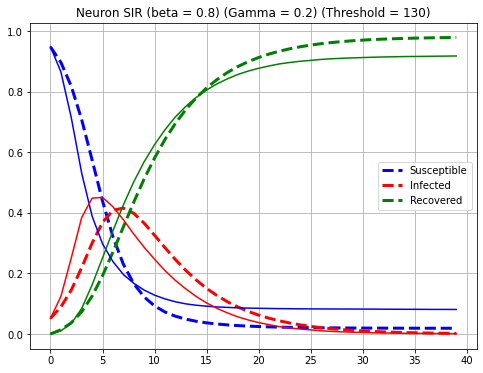

Fraction unfired: 0.11009174311926606


In [25]:
simulation_params = {}

simulation_params['Time'] = 40
simulation_params['Runs'] = 100

simulation_params['Initial'] = 0.05
simulation_params['Beta'] = 0.8
simulation_params['Gamma'] = 0.2

simulation_params['Threshold'] = 65*2 # only affects simulation

#simulation_params['Increment'] = 0.1 # unused
#simulation_params['Decay'] = 1 # not reall IF , should be some kind of expnenetial

G = nm.build_nxgraph(dataset_paths[3], False) 
#G = nx.erdos_renyi_graph(1000, 0.15)
#G = initialise_weight(G, 1)
G = comparison(G, simulation_params, 'original')
print('Fraction unfired: ' + str(check_susecptible(G)))


In [ ]:
# Figure out why analytical solution and model go beyond population size for certain parameters
# See if decay is holding back accuracy
# visualise spread for presentation
# for future, give better estimates on dates and timescales over which we expect change and account for features like weekends and holidays.

# Figuring out decay mechanism

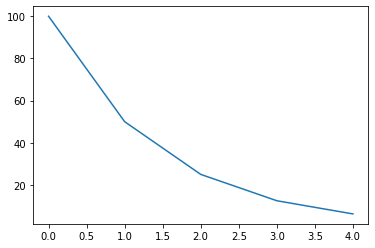

In [ ]:
# checking if the potential decays is reasonable
plt.plot([0, 1, 2, 3, 4], [100, 50, 25, 12.5, 6.25])

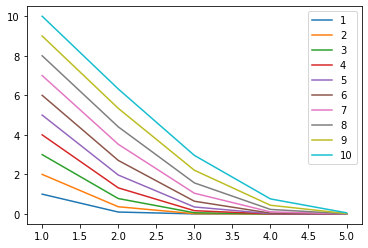

In [ ]:
th = 10

for i in range(1,11):
    pot = i
    x = np.linspace(1, 5, 5) # time
    y = [pot]
    for j in range(len(x)-1):
        y.append(pot - pot*np.exp(-pot/th))
        pot = y[-1]

    plt.plot(x, y, label = i)
    plt.legend(loc = 'upper right')

In [ ]:
1-np.exp(-0.4)

0.3296799539643607

# Comparing with normal SIR (weighted)

In [ ]:
def initialise_basic(H, params):
    for node in list(H.nodes): # initialise 
        if np.random.random() < params['Initial']: # infect some percentage of nodes
            H.nodes[node]['status'] = 0
        else:
            H.nodes[node]['status'] = 1
    return H

def basic_sir(H, params): # uses list for updating -> prone to error
    H = initialise_basic(H, params)
    S = []
    I = []
    R = []
    s, i, r = check_states(H)
    S.append(s)
    I.append(i)
    R.append(r)
    for i in range(params['Time']):
        print(i)
        update_list = []
        count = 0
        for node in list(H.nodes):
            if H.nodes[node]['status'] == 0:
                connections = list(H.neighbors(node))
                for connection in connections:
                    stat = params['Beta'] * H[node][connection]['weight']
                    if np.random.random() < stat:
                        count += 1
                        #H.nodes[connection]['status'] = 0
                        update_list.append(connection)
        #print(stat)
        #print(count)
        #print(check_activity(H)*len(H))
        
        for node in list(H.nodes): # move nodes to removed state
            if H.nodes[node]['status'] == 0:
                if np.random.random() < params['Gamma']:
                    H.nodes[node]['status'] = -1
                    
        for node in update_list: # infect nodes
            if H.nodes[node]['status'] == 1:
                H.nodes[node]['status'] = 0 
                    
        s, i, r = check_states(H)
        S.append(s)
        I.append(i)
        R.append(r)
        
    return S, I, R

        
def smooth_basic(H, params):
    s_smooth = []
    i_smooth = []
    r_smooth = []
    s_runs = []
    i_runs = []
    r_runs = []
    
    M = params['Runs']
    T = params['Time']
    
    for i in range(M):
        print(i)
        #print(str(round((i+1)*100/M, 1)) + '%') # display progress of smoothing
        s_run, i_run, r_run = simulate_sir(H, params)
        s_runs.append(s_run)
        i_runs.append(i_run)
        r_runs.append(r_run)
    
    for i in range(T): # smoothing susceptible time series
        total = 0
        for j in range(M):
            total += s_runs[j][i]     
        total = total / M   
        s_smooth.append(total)
        
    for i in range(T): # smoothing infected time series
        total = 0
        for j in range(M):
            total += i_runs[j][i]     
        total = total / M   
        i_smooth.append(total)

    for i in range(T): # smoothing recovered time series
        total = 0
        for j in range(M):
            total += r_runs[j][i]     
        total = total / M   
        r_smooth.append(total)
        
    return s_smooth, i_smooth, r_smooth
    
def rescale_weights(H):
    weights = []
    
    for node in list(H.nodes):
        connections = H.neighbors(node)
        for connection in connections:
            old = H[node][connection]['weight']
            new = np.log10(old)
            weights.append(new)
            H[node][connection]['weight'] = new
    
    norm = max(weights)
    print(norm)
    
    for node in list(H.nodes):
        connections = H.neighbors(node)
        for connection in connections:
            H[node][connection]['weight'] /= norm
    
    return H
    
            
def test_sir(H, params): # runs 1 time step
    update_dict = {}
    r0 = params['Beta'] / params['Gamma']
    infection_prob = np.exp(-r0)
    #print(len(update_dict)/ len(G))
    for node in list(H.nodes):
        if H.nodes[node]['status'] == 0:
            connections = list(H.neighbors(node))
            for connection in connections:
                stat = H[node][connection]['weight'] * infection_prob
                if np.random.random() < stat:
                    update_dict[connection] = 0

    for node in list(H.nodes):
        if H.nodes[node]['status'] == 0:
            if np.random.random() < params['Gamma']:
                H.nodes[node]['status'] = -1
    
    for node in list(update_dict.keys()):
        if H.nodes[node]['status'] == 1:
            H.nodes[node]['status'] = 0
    return H

def test_sir(H, params):
    update_dict = {}
    r0 = params['Beta'] / params['Gamma']
    infection_prob = np.exp(-r0)
    nodes = list(H.nodes)
    for node in nodes:
        if H.nodes[node]['status'] == 0:
            connection = random.choice(nodes)
            if H.nodes[connection]['status'] == 1:
                stat = 1 * params['Beta']
                if np.random.random() < stat:
                    update_dict[connection] = 0
                    
    for node in list(H.nodes):
        if H.nodes[node]['status'] == 0:
            if np.random.random() < params['Gamma']:
                H.nodes[node]['status'] = -1
    
    for node in list(update_dict.keys()):
        H.nodes[node]['status'] = 0  
    
    return H
    

def simulate_sir(H, params):
    H = initialise_basic(H, params)
    S = []
    I = []
    R = []
    s, i, r = check_states(H)
    S.append(s)
    I.append(i)
    R.append(r)
    for i in range(params['Time']):
        H = test_sir(H, params)
        s, i, r = check_states(H)
        S.append(s)
        I.append(i)
        R.append(r)
    return S, I, R
    
    

(0.636085626911315, 0.0, 0.363914373088685)


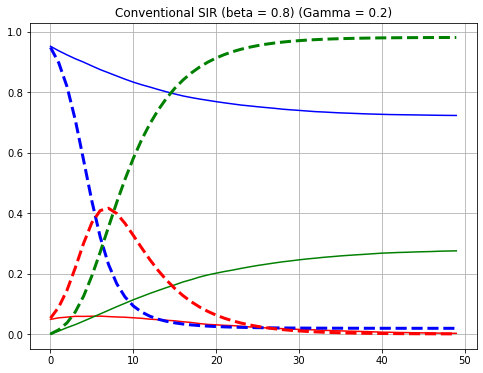

In [ ]:
# Numerical SIR

# infect some part of the population then start to move through time from data.
simulation_params = {}
simulation_params['Time'] = 50
simulation_params['Runs'] = 100
simulation_params['Initial'] = 0.05
simulation_params['Beta'] = 0.8
simulation_params['Gamma'] = 0.2

H = nm.build_nxgraph(dataset_paths[3], True) 
#H = initialise_weight(H, 1)
#H = rescale_weights(H)

s, i, r = smooth_basic(H, simulation_params)
S, I, R = analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('Conventional SIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

  
plt.grid()
#plt.legend(loc = 'upper right')
print(check_states(H))

In [ ]:
simulation_params = {}

simulation_params['Time'] = 10
simulation_params['Runs'] = 1

simulation_params['Initial'] = 0.05
simulation_params['Beta'] = 0.5
simulation_params['Gamma'] = 0.3

H = nm.build_nxgraph(dataset_paths[3], True) 
print(len(H))
#H = initialise_weight(H, 1)
H = initialise_basic(H, simulation_params)
print(check_states(H))
H = test_sir(H, simulation_params)
print(check_states(H))


327
(0.9418960244648318, 0.0581039755351682, 0.0)
2
(0.9357798165137615, 0.03669724770642202, 0.027522935779816515)


In [ ]:
simulation_params = {}

simulation_params['Time'] = 10
simulation_params['Runs'] = 1

simulation_params['Initial'] = 0.05
simulation_params['Beta'] = 0.5
simulation_params['Gamma'] = 0.3


H = nm.build_nxgraph(dataset_paths[3], True) 

#d, w = ns.analyse_graph(H)
#plt.hist(w)

H = initialise_weight(H, 1)
H = initialise_basic(H, simulation_params)

#d, w = ns.analyse_graph(H)
#plt.hist(w)

params = simulation_params

update_dist = {}
count = 0
total = 0
sum = 0
print(check_activity(H))
    
print(check_activity(H))

print(sum) # num infected
print(total)
print(count)

# the problem is occurring because the same connections can be counted for multiple infected nodes

0.039755351681957186
0.08256880733944955
1
26
15


# Comparing with SIR conditions

In [ ]:
'''
Build network following SIR assumptions of uniform mixing
and uniform weight
'''
    
def SIR_assumptions_graph(degree, size):
    degree_dist = []
    for i in range(size):
        degree_dist.append(degree)
    H = nx.configuration_model(degree_dist, create_using = nx.Graph)
    H = initialise_weight(H, 1)
    return H

degree = 75 # this has become irrelevant alhamdullilah
size = 100000
#H = SIR_assumptions_graph(degree, size)
H = nx.empty_graph(size)
#H = nx.complete_graph(size)
#H = initialise_weight(H, 1) 
print('Graph constructed')


Graph constructed


0
1
2
3
4
5
6
7
8
9


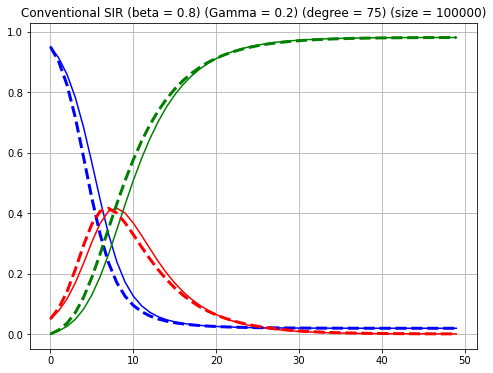

In [ ]:
simulation_params = {}
simulation_params['Time'] = 50
simulation_params['Runs'] = 10
simulation_params['Initial'] = 0.05
simulation_params['Beta'] = 0.8
simulation_params['Gamma'] = 0.2

s, i, r = smooth_basic(H, simulation_params)
S, I, R = analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('Conventional SIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (degree = ' +str(degree)+ ') (size = ' + str(size) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.grid()

In [ ]:
nodes = list(H.nodes)
connection = random.choice(nodes)
print(connection)
print(H.nodes[connection]['status'])

282
1


In [ ]:
H.nodes[201]

{'status': 1}

In [ ]:
# probing graph

node_measures = ns.measure_nodes(H)
network_measures = ns.measure_network(H)

print('Node measures')
ns.print_dict(node_measures)
print('Network measures')
ns.print_dict(network_measures)

In [ ]:
# visualisating spread
# this gives an error in that it is not able to draw a large graph
# wait a sec, H only had 100 nodes ...



simulation_params = {}
simulation_params['Time'] = 50
simulation_params['Runs'] = 100 # irrelevant to visualization
simulation_params['Initial'] = 0.05
simulation_params['Beta'] = 0.8
simulation_params['Gamma'] = 0.2
simulation_params['Threshold'] = 65*2 # only affects simulation


def visualise_basic(G, params, seed_val):
    files = glob.glob('/Users/ali/MSci Project/IF visualisation basic/frame*.png')
    for f in files:
        os.remove(f)

    G = initialise_basic(G, params)
    plt.figure(figsize = (12, 8))
    if seed_val == None:
        positions = nx.spring_layout(G)
    else:
        positions = nx.spring_layout(G, seed = seed_val)
    
    colours = find_colours(G)
    plt.text(10,10,'time')
    nx.draw_networkx(G, pos = positions, with_labels = 0, node_size = 100, node_color = colours, alpha = 0.5)
    plt.savefig('/Users/ali/MSci Project/IF visualisation/frame' + str(0))
    plt.clf()
    
    for t in range(params['Time']):
        G = test_sir(G, params)
        colours = find_colours(G)
        nx.draw_networkx(G, pos = positions, with_labels = 0, node_size = 100, node_color = colours, alpha = 0.5)
        plt.savefig('/Users/ali/MSci Project/IF visualisation/frame' + str(t+1))
        plt.clf()
    

def make_gif(folder_path, save_path):
    frames = []
    imgs = []
    path = folder_path + 'frame'
    total_frames = len(os.listdir(folder_path))
    for i in range(total_frames):
        imgs.append(path + str(i) + '.png')
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)

    frames[0].save(save_path, 
                format='GIF',
                append_images=frames[1:],
                save_all=True,
                duration=500) # duration of each frame in milliseconds!
    return frames

visualise_basic(H, simulation_params, None)
make_gif('/Users/ali/MSci Project/basic SIR visualisation/', '/Users/ali/MSci Project/basic SIR visualisation.gif')

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

<Figure size 864x576 with 0 Axes>

# Testing propagation algorithm

In [ ]:
# checking that things are proceeding as expected

def test_sir(H):
    update_list = []
    
    for node in list(H.nodes):
        if H.nodes[node]['status'] == 0:
            connections = list(H.neighbors(node))
            for connection in connections:
                stat = H[node][connection]['weight'] * 0.5
                if np.random.random() < stat:
                    update_list.append(connection)
    
    for node in list(H.nodes):
        if H.nodes[node]['status'] == 0:
            if np.random.random() < 0.5:
                H.nodes[node]['status'] = -1
    
    print(update_list)
    for node in update_list:
        if H.nodes[node]['status'] == 1:
            H.nodes[node]['status'] = 0 
    
    return H

def test_sir(H): # runs 1 time step
    update_dict = {}
    #print(len(update_dict)/ len(G))
    for node in list(H.nodes):
        if H.nodes[node]['status'] == 0:
            connections = list(H.neighbors(node))
            for connection in connections:
                stat = H[node][connection]['weight'] * 0.5
                if np.random.random() < stat:
                    update_dict[connection] = 0

    for node in list(H.nodes):
        if H.nodes[node]['status'] == 0:
            if np.random.random() < 0.5:
                H.nodes[node]['status'] = -1
    
    #print(len(update_dict)/ len(G))
    print(update_dict)
    for node in list(update_dict.keys()):
        if H.nodes[node]['status'] == 1:
            H.nodes[node]['status'] = 0
    return H

T = nx.Graph()
T.add_edge(0,1)
T.add_edge(0,2)
T.add_edge(1,2)
T[0][1]['weight'] = 1
T[0][2]['weight'] = 1
T[1][2]['weight'] = 1

T.nodes[0]['status'] = 0
T.nodes[1]['status'] = 1
T.nodes[2]['status'] = 1

for node in list(T.nodes):
    if T.nodes[node]['status'] == 0:
        connections = list(T.neighbors(node))
    print(str(node) + ' : ' + str(T.nodes[node]))
print('\n')

T = test_sir(T)
for node in list(T.nodes):
    if T.nodes[node]['status'] == 0:
        connections = list(T.neighbors(node))
    print(str(node) + ' : ' + str(T.nodes[node]))
print('\n')

T = test_sir(T)
for node in list(T.nodes):
    if T.nodes[node]['status'] == 0:
        connections = list(T.neighbors(node))
    print(str(node) + ' : ' + str(T.nodes[node]))
print('\n')

T = test_sir(T)
for node in list(T.nodes):
    if T.nodes[node]['status'] == 0:
        connections = list(T.neighbors(node))
    print(str(node) + ' : ' + str(T.nodes[node]))
print('\n')

T = test_sir(T)
for node in list(T.nodes):
    if T.nodes[node]['status'] == 0:
        connections = list(T.neighbors(node))
    print(str(node) + ' : ' + str(T.nodes[node]))
print('\n')

0 : {'status': 0}
1 : {'status': 1}
2 : {'status': 1}


{1: 0}
0 : {'status': -1}
1 : {'status': 0}
2 : {'status': 1}


{}
0 : {'status': -1}
1 : {'status': 0}
2 : {'status': 1}


{0: 0}
0 : {'status': -1}
1 : {'status': 0}
2 : {'status': 1}


{0: 0, 2: 0}
0 : {'status': -1}
1 : {'status': -1}
2 : {'status': 0}




# Visualisation

In [ ]:
# Visualisation of a single run

simulation_params = {}

simulation_params['Time'] = 40
simulation_params['Runs'] = 100 # irrelevant to visualization

simulation_params['Initial'] = 0.05
simulation_params['Beta'] = 0.8
simulation_params['Gamma'] = 0.2

simulation_params['Threshold'] = 65*2 # only affects simulation


G = nm.build_nxgraph(dataset_paths[3], False) 

visualise(G, simulation_params, None)
make_gif()

[<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=864x576 at 0x7F8C015822B0>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=864x576 at 0x7F8C01582A90>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=864x576 at 0x7F8C01582220>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=864x576 at 0x7F8C01582A30>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=864x576 at 0x7F8C0156D700>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=864x576 at 0x7F8C0156D3D0>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=864x576 at 0x7F8C0156D400>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=864x576 at 0x7F8C0156D4F0>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=864x576 at 0x7F8C0156D1F0>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=864x576 at 0x7F8C0156D370>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=864x576 at 0x7F8C0156D9A0>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=864x576 at 0x7F8C0156DA00>,
 <PI

<Figure size 864x576 with 0 Axes>

In [ ]:
a = 'abc'
print(a[:-2])

a
